In [1]:
## TEXT MINING PROJECT 21/22

# BlackBerry

#Angie Kief 20211913
#Francisco Ornelas 20210660
#Luís Santos 20210694

In [2]:
!pip install contractions

### 1. Import Libraries


In [3]:
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import nltk
import re
import contractions

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Lambda
import tensorflow as tf

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense


In [4]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jrs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Defining vector space dimension and fixed input size

In [5]:
# Number of labels:1: Anger, 2: Anticipation, 3: Disgust, 4: Fear, 5: Joy,
# 6: Sadness, 7: Surprise, 8: Trust

num_classes = 8

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 63

class_names = ['1\n','2\n','3\n','4\n','5\n','6\n','7\n','8\n']

### 2. Data Import

First, we need to open the .txt files of the train and development sets and read the document line by line. The sentence and the emotion label in each line are seperated by a tab. We  will create an empty pandas data frame with the columns "Sentence" and "Emotion", split every line by "\t" and store the to parts in the respective columns.

In [6]:
lines = []

with open('training_set.txt') as f:
    lines = f.readlines()

lines.pop(0)

df_train = pd.DataFrame(columns=['Sentence', 'Emotion'])

for l in lines:
  l_string = str(l)
  l_split = l_string.split("\t")
  df_train = df_train.append({'Sentence': l_split[0], 'Emotion': l_split[1]}, ignore_index=True)

df_train.shape

(14000, 2)

In [7]:
lines_2 = []

with open('dev_set.txt') as f:
    lines_2 = f.readlines()

lines_2.pop(0)

df_dev = pd.DataFrame(columns=['Sentence', 'Emotion'])

for l in lines_2:
  l_string = str(l)
  l_split = l_string.split("\t")
  df_dev = df_dev.append({'Sentence': l_split[0], 'Emotion': l_split[1]}, ignore_index=True)


df_dev.shape

(1000, 2)

Then, we have to initialise our train and dev data.

In [8]:
X_train = df_train['Sentence']
X_dev = df_dev['Sentence']

y_train = df_train['Emotion']
y_dev = df_dev['Emotion']

data = df_train.append(df_dev, ignore_index=True)

In [9]:
print(data.Emotion.value_counts())
data.head(6)

1\n    3210
2\n    2299
8\n    2253
5\n    1567
4\n    1546
6\n    1471
3\n    1420
7\n    1234
Name: Emotion, dtype: int64


,Sentence,Emotion
0,I'm too old to be traded in .,6\n
1,Mother said you could always tell a lady by he...,8\n
2,I always said I'd leave off when the time came .,6\n
3,He'll be safe with me .,2\n
4,Lay off .,1\n
5,You tell him to take care of you .,8\n


### 3. Preprocessing
To input the data to our NN Model we will need some preprocessing:

1.   Clean the data by resolving contractions and removing everything that is not plain text
2.   Tokenize the sentences and count unique tokens
3.   Padding: each input has to be of the same lenght
4.   Labels have to be converted to integeres and categorized


#### 3.1 Data Cleaning

In [10]:
def clean_text(data):
    
    #resolve contractions
    data = contractions.fix(data)
    
    #REMOVE THAT IS NOT TEXT
    data = re.sub("[^a-zA-Z]", ' ', data)
    
    #REMOVE STOP WORDS
    #data = ' '.join([word for word in data.split() if word not in stop])
        
    #REMOVE UNWANTED SPACES
    data = re.sub('  ', ' ', data)

    #remove hyperlinks
    #data = re.sub(r'((www\.[\S]+)|(https?://[\S]+))', '', data)

    #remove special characters
    #pattern = re.compile('([^\s\w]|_)+', re.UNICODE)
    #data = pattern.sub('', data)
    
    # tokenization using nltk
    data = word_tokenize(data)
    #print(data)
    
    return data

In [11]:
texts = [' '.join(clean_text(text)) for text in data.Sentence]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_dev = [' '.join(clean_text(text)) for text in X_dev]

In [12]:
print(texts_train)

['I am too old to be traded in', 'Mother said you could always tell a lady by her hands', 'I always said I would leave off when the time came', 'He will be safe with me', 'Lay off', 'You tell him to take care of you', 'I hope so', 'Why do you want to shut me out in the cold like this', 'You taught me a lesson man', 'I will do everything I can to make a success of it', 'But it was worth it', 'I hope I never wake up', 'Alright here is how it works', 'Flo being a parent is about sharing', 'He looks like a drunk', 'Primitive', 'Hello Never ever pick up the phone', 'PERSON could I have a word with you', 'I am not resigning my senior partnership the day after what happened happened if that is what you are asking', 'It is OK', 'Why do not you sit down and try not to waste my time', 'Find someone to type this', 'You are too nice', 'It is time to update the program and I would like to hear from each one of you', 'I have lost another man and that bastard thinks it is funny', 'I hope you know tha

#### 3.2 Tokenization and Padding using Keras

In [13]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_dev = tokenizer.texts_to_sequences(texts_dev)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 7697


We have to add padding so that each input sentence has the same length.


In [14]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_dev_pad = pad_sequences(sequence_dev, maxlen = max_seq_len )

X_train_pad

array([[   0,    0,    0, ...,   26, 3783,   18],
       [   0,    0,    0, ...,  112,   61,  361],
       [   0,    0,    0, ...,    4,   77,  402],
       ...,
       [   0,    0,    0, ...,  261, 7440,   99],
       [   0,    0,    0, ...,   90,    6,  206],
       [   0,    0,    0, ...,    4,  626, 1902]])

#### 3.3 Label Categorization

In [15]:
#Categorize Labels
encoding = {
    '1\n': 0,
    '2\n': 1,
    '3\n': 2,
    '4\n': 3,
    '5\n': 4,
    '6\n': 5,
    '7\n': 6,
    '8\n': 7
}

# Integer labels
y_train = [encoding[x] for x in df_train.Emotion]
y_dev = [encoding[x] for x in df_dev.Emotion]

In [16]:
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)

y_train

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

### 4. Import pretrained Embeddings

For this project 1 million word vectors trained on Wikipedia 2017, UMBC webbase corpus and statmt.org news dataset (16B tokens) willl be used.

In [17]:
def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [18]:
import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [19]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(7698, 300)

In [20]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 7541
New words found: 156


### 5. GRU Pipeline

In [21]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

In [22]:
# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [23]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 63, 300)           2309400   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              330240    
 l)                                                              
                                                                 
 dense (Dense)               (None, 8)                 2056      
                                                                 
Total params: 2,641,696
Trainable params: 332,296
Non-trainable params: 2,309,400
_________________________________________________________________


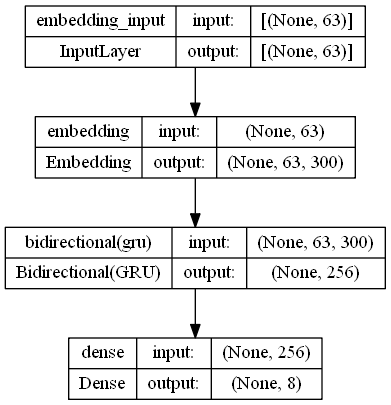

In [24]:
img_file = './model_arch.png'

tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)

### 6. Model Training

In [25]:
batch_size = 128
epochs = 15

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_dev_pad,y_dev))

Epoch 1/15
110/110 [==============================] - 89s 778ms/step - loss: 1.9315 - accuracy: 0.2654 - val_loss: 1.8174 - val_accuracy: 0.3180
Epoch 2/15
110/110 [==============================] - 83s 758ms/step - loss: 1.7145 - accuracy: 0.3654 - val_loss: 1.6748 - val_accuracy: 0.3760
Epoch 3/15
110/110 [==============================] - 83s 754ms/step - loss: 1.6329 - accuracy: 0.4022 - val_loss: 1.6336 - val_accuracy: 0.3820
Epoch 4/15
110/110 [==============================] - 93s 848ms/step - loss: 1.5858 - accuracy: 0.4219 - val_loss: 1.6183 - val_accuracy: 0.4030
Epoch 5/15
110/110 [==============================] - 95s 865ms/step - loss: 1.5586 - accuracy: 0.4326 - val_loss: 1.6036 - val_accuracy: 0.4140
Epoch 6/15
110/110 [==============================] - 94s 856ms/step - loss: 1.5360 - accuracy: 0.4409 - val_loss: 1.5903 - val_accuracy: 0.4170
Epoch 7/15
110/110 [==============================] - 98s 895ms/step - loss: 1.5204 - accuracy: 0.4416 - val_loss: 1.5847 - val_ac

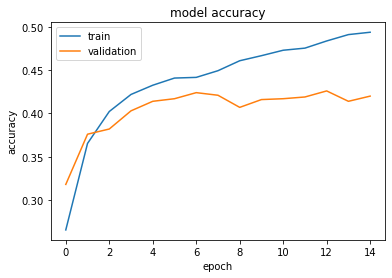

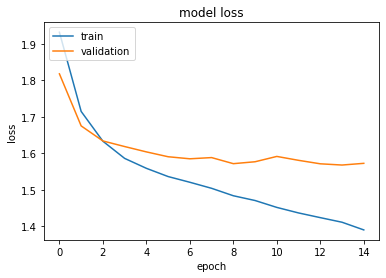

In [26]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### 4. Evaluation

In [27]:
predictions = model.predict(X_dev_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

32/32 [==============================] - 4s 100ms/step


In [28]:
# SAVE TO dev_results.txt

df_dev_pred = pd.DataFrame()
df_dev_pred['Sentence'] = df_dev['Sentence']
df_dev_pred['Emotion'] = predictions

df_dev_pred.to_csv('dev_results.csv',index=False)

import csv
csv_file = 'dev_results.csv'
txt_file = 'dev_results.txt'
with open(txt_file, "w") as my_output_file:
    with open(csv_file, "r") as my_input_file:
        [ my_output_file.write("\t".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

In [29]:
print("Accuracy: {:.2f}%".format(accuracy_score(df_dev.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(df_dev.Emotion, predictions, average='micro') * 100))

Accuracy: 42.00%

F1 Score: 42.00


In [30]:
from sklearn.metrics import classification_report

labels = {"Anger": 1, "Anticipation": 2, "Disgust": 3, "Fear": 4, "Joy": 5, "Sadness": 6, "Surprise": 7, "Trust": 8}
print(classification_report(predictions, np.array(df_dev["Emotion"]), target_names=labels.keys()))

              precision    recall  f1-score   support

       Anger       0.51      0.45      0.48       238
Anticipation       0.54      0.44      0.49       208
     Disgust       0.22      0.40      0.28        43
        Fear       0.35      0.39      0.37        92
         Joy       0.43      0.44      0.44        96
     Sadness       0.39      0.30      0.34       114
    Surprise       0.32      0.41      0.36        76
       Trust       0.39      0.46      0.42       133

    accuracy                           0.42      1000
   macro avg       0.39      0.41      0.40      1000
weighted avg       0.44      0.42      0.42      1000



#### Confusion Matrix

In [31]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 42.00


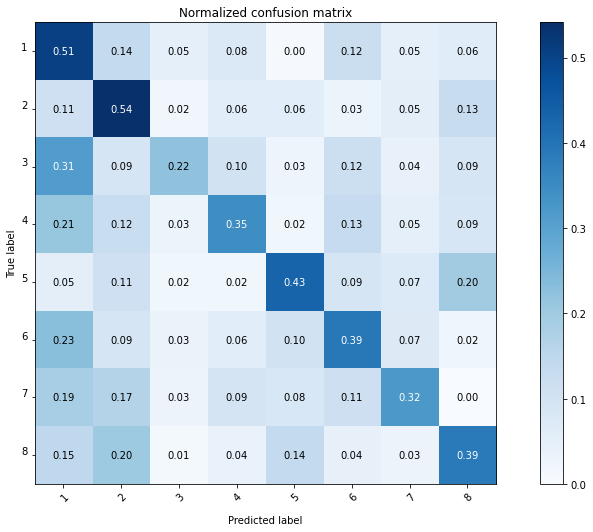

In [32]:
print("\nF1 Score: {:.2f}".format(f1_score(df_dev.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(df_dev.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

C:\Users\jrs\AppData\Local\Temp/ipykernel_10644/2435035352.py:42: UserWarning: Attempting to set identical bottom == top == 7.5 results in singular transformations; automatically expanding.
  plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged


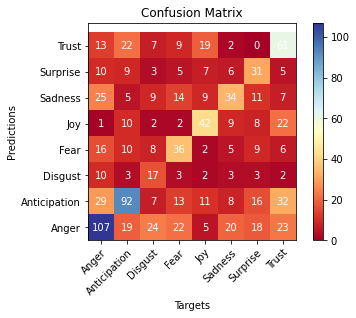

In [33]:
import numpy as np
import matplotlib.pyplot as plt

def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.RdYlBu)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],
                           ha="center", va="center", color="w")

    ax.set_title("Confusion Matrix")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

plot_cm(confusion_matrix(predictions, np.array(df_dev["Emotion"])), labels.keys())

### 5. Predict test set

In [34]:
#import test set

lines_3 = []

with open('test_set.txt') as f:
    lines_3 = f.readlines()

lines_3.pop(0)

df_test = pd.DataFrame(columns=['Sentence'])

for l in lines_3:
  l_string = str(l)
  l_split = l_string.split("\t")
  df_test = df_test.append({'Sentence': l_split[0]}, ignore_index=True)


df_test.shape

(2000, 1)

In [35]:
# input data prep

from tqdm.notebook import tqdm 

def clean_newline(text_list):
    """
    removes \n given a list of text
    """
    updates = []
    for j in tqdm(range(len(text_list))):

        text = text_list[j]
        
        # REMOVE \n
        text =re.sub("\n","",text)
        
        updates.append(text)
    
    return updates  
        
def update_df(dataframe, list_updated):
    dataframe.update(pd.DataFrame({"Sentence": list_updated}))
    

    
updates_test = clean_newline(df_test["Sentence"])
update_df(df_test, updates_test)

df_test.head(5)

  0%|          | 0/2000 [00:00<?, ?it/s]

,Sentence
0,"Come , let's go get that automobile ."
1,"Well , some other time , then ?"
2,He's in trouble . Boy ?
3,Criminal gang unit to take control .
4,By Molto . No discussion . Interview .


In [36]:
X_test = df_test['Sentence']

texts_test = [' '.join(clean_text(text)) for text in X_test]

In [37]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 7697


In [38]:
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_test_pad

array([[  0,   0,   0, ...,  58,  33,   9],
       [  0,   0,   0, ..., 215,  77, 110],
       [  0,   0,   0, ...,  18, 226, 151],
       ...,
       [  0,   0,   0, ...,  11,   1,  15],
       [  0,   0,   0, ...,   0,  21,   9],
       [  0,   0,   0, ...,   9,  40,  26]])

In [39]:
predictions_test = model.predict(X_test_pad)
predictions_test = np.argmax(predictions_test, axis=1)
predictions_test = [class_names[pred] for pred in predictions_test]

df_test['Emotion'] = predictions_test

63/63 [==============================] - 7s 104ms/step


In [40]:
# SAVE TO test_results.txt

df_test.to_csv('test_results.csv',index=False)

import csv
csv_file = 'test_results.csv'
txt_file = 'test_results.txt'
with open(txt_file, "w") as my_output_file:
    with open(csv_file, "r") as my_input_file:
        [ my_output_file.write("\t".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

#### Save our Model

In [41]:
# creates a HDF5 file 'my_model.h5'
model.save('models/GRU_w2v.h5')

In [42]:
from keras.models import load_model
predictor = load_model('models/GRU_w2v.h5')